<div style="color:#ffffff; 
          font-size:50px; 
          font-style:italic; 
          text-align:left;
          font-family: 'Lucida Bright';
          background:#4686C8;">
  	&nbsp; Keras Tuning
</div>
<br>   
<div style="
          font-size:20px; 
          text-align:left;
          font-family: 'Palatino';
          ">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Project: Keras Tuning<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Author: George Barrinuevo<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Date: 06/21/2025<br>
</div>

In [1]:
import os
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import layers, models, applications
from tensorflow.keras.models import Sequential
from keras.layers import Lambda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"    # If set to '-1 ' will disable using CUDA GPU.

2025-06-23 19:11:20.733240: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-23 19:11:20.733874: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-23 19:11:20.737208: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-23 19:11:20.745522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750731080.759792   28572 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750731080.76

In [2]:
# pip install -q -U keras-tuner

<br><div style="color:#ffffff; 
          font-size:30px; 
          font-style:italic; 
          text-align:left;
          font-family: 'Lucida Bright';
          background:#4686C8;">
  	      &nbsp; Load Dataset
</div>
<div style="
          font-size:16px; 
          text-align:left;
          font-family: 'Cambria';">
The Keras MNIST is a dataset of images of the 10 digits. This is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. The dataset info can be found here: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; https://keras.io/api/datasets/mnist/<br>
The models used in this notebook have parameters that rely on the images to be of size (224, 224, 3) in the format (height, width, channels). Changing the image to another size will require changing the models parameters. Also, the model requires the input images be in RGB format. A conversion from grayscale to RGB color is required.<br>
<br>
The my_shuffle_ndarry() is used to shuffle the X and Y dataset.
</div>

In [3]:

input_shape = (224, 224, 3)

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Used to shuffle the dataset.
def my_shuffle_ndarry(in_X, in_Y):
    t_shape = in_X.shape[0]
    # print(f't_shape: {t_shape}')
    indices = np.arange(t_shape)
    np.random.shuffle(indices)
    # print(f'indices: {indices}')
    out_X = in_X[indices]
    out_Y = in_Y[indices]
    return (out_X, out_Y)

X_train, y_train = my_shuffle_ndarry(X_train, y_train)

print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'{(X_train.dtype)}')

t_min = float(X_train.min())
t_max = float(X_train.max())
print(f'Min value: {t_min}, Max value: {t_max}')

X_train.shape: (60000, 28, 28)
y_train.shape: (60000,)
X_test.shape: (10000, 28, 28)
y_test.shape: (10000,)
uint8
Min value: 0.0, Max value: 255.0


<br>
<div style="color:#ffffff; 
          font-size:30px; 
          font-style:italic; 
          text-align:left;
          font-family: 'Lucida Bright';
          background:#4686C8;">
  	      &nbsp; Plot Some Images
</div>
<br>
<div style="
          font-size:16px; 
          text-align:left;
          font-family: 'Cambria';">
Some images are plotted.
</div>

class_names: [0 1 2 3 4 5 6 7 8 9]
num_classes: 10
X_train.shape: (60000, 28, 28)


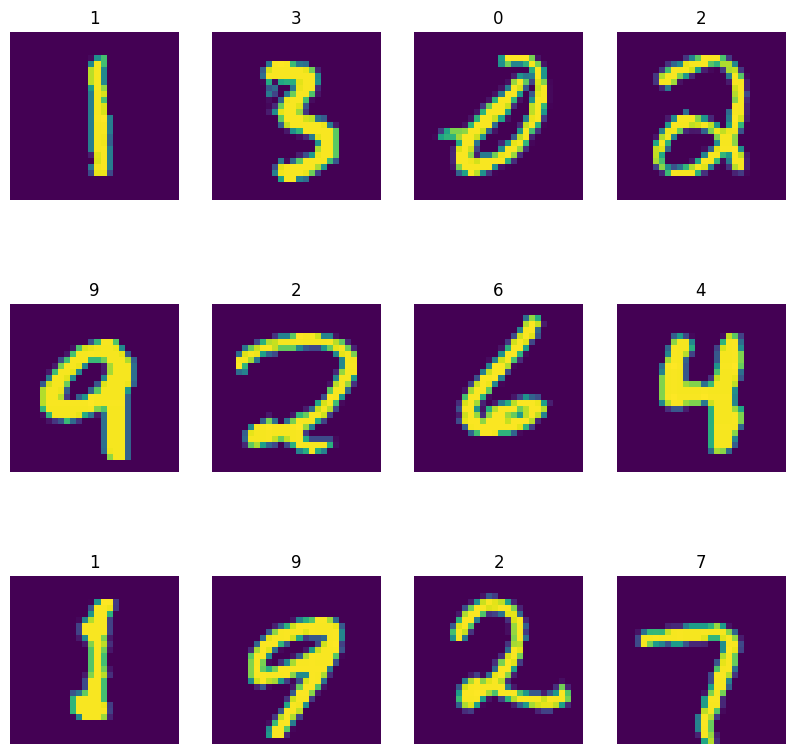

In [4]:
%matplotlib inline
class_names = np.unique(y_train, axis=0)
num_classes = len(class_names)
print(f'class_names: {class_names}')
print(f'num_classes: {num_classes}')
print(f'X_train.shape: {X_train.shape}')

plt.figure(figsize=(10,10))
for i in range(12):
    image = X_train[i]
    label = y_train[i]
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis("off")

<br>
<div style="color:#ffffff; 
          font-size:30px; 
          font-style:italic; 
          text-align:left;
          font-family: 'Lucida Bright';
          background:#4686C8;">
  	      &nbsp; Normalize and Convert to RGB
</div>
<br>
<div style="
          font-size:16px; 
          text-align:left;
          font-family: 'Cambria';">

<b>my_grayscale_to_RGB()</b><br>
This function will convert a grayscale dataset to RGB color format. Here are some details of how this is done.<br>
This command will convert the 1 row vector to n rows. The shape of (1, 4) is converted to (4, 1):<br>
&emsp; &emsp;   command: X_train[:, np.newaxis]<br>
&emsp; &emsp; 	from: array([0, 1, 2, 3])<br>
&emsp; &emsp; 	to: array([[0], [1], [2], [3]])<br>
This is the other command used. The shape of (4, 1) is converted to (4, 3). It replicates the values in each row repeats=3 times:<br>
&emsp; &emsp;   command: np.repeat(, repeats=3, axis=-1)<br>
&emsp; &emsp; 	from: from: array([[0], [1], [2], [3]])<br>
&emsp; &emsp; 	from: to: array([[0, 0, 0], [1, 1, 1], [2, 2, 2], [3, 3, 3]])<br>
The Grayscale to RGB conversion requires that the Grayscale values are copied to the R, G, B layers, such that R = G = B. Apply this to the entire training X dataset. Do NOT apply this to the training Y dataset. It is not necessary to apply this to the Test dataset since the training/fitting is done on the Train dataset.<br>
<br>
<b>my_normalize()</b><br>
This function will normalize the dataset by converting the image values from [0, 255] range to [0, 1] range which is more efficient for the algorithms to process. This command can be called directly, or included in the model using the Lambda() function. Alternatively, you can use the tf.keras.layers.Resizing() added to the model. But only call one of these only one times. This script uses the following variables to select 1 of 3 ways to perform normalization used for educational purposes:
- 'use_normalization_method' - Possible values are 'model-external-function', 'model-builtin', 'external-function'.

The resizing to 224 x 224 pixels image size is needed since the models below have parameters that matches this size.<br>
</div>



In [5]:
def my_normalize(X):   
    new_X = X / 255.0
    return new_X

def my_grayscale_to_RGB(ds):
    # print(f'before operations: ds.shape: {ds.shape}')  # (64, 224, 224)
    ds = ds[..., np.newaxis]
    # print(f'after newaxis: ds.shape: {ds.shape}')
    ds = np.repeat(ds, repeats=3, axis=-1)
    # print(f'after repeat: ds.shape: {ds.shape}')  # (64, 224, 224, 3)
    # print('------')
    return ds
    
use_normalization_method = 'model-external-function'    # Values: 'model-external-function', 'model-builtin', 'external-function'

if not use_normalization_method in ['model-external-function', 'model-builtin', 'external-function']:
    print(f"For the script parameter 'use_normalization_method', the value '{use_normalization_method}' is unknown")
    # This is used to exit the script in a Jupyter notebook.
    print('Exiting the script.')
    assert(False)
    
resize_and_rescale = tf.keras.Sequential()
resize_and_rescale.add(tf.keras.layers.Resizing(224, 224))

if use_normalization_method == 'model-external-function':
    print(f'Adding my_normalize() to the model')
    resize_and_rescale.add(Lambda(my_normalize))
elif use_normalization_method == 'model-builtin':
    print(f'Adding normalizing method tf.keras.layers.Rescaling() to the model')
    resize_and_rescale.add(tf.keras.layers.Rescaling(1./255))

if use_normalization_method == 'external-function':
    print(f'Calling my_normalize() directly')
    X_train = my_normalize(X_train)
    X_test = my_normalize(X_test)
    
X_train = my_grayscale_to_RGB(X_train)
X_test = my_grayscale_to_RGB(X_test)

t_min = float(X_train.min())
t_max = float(X_train.max())
print(f'Min value: {t_min}, Max value: {t_max}')


Adding my_normalize() to the model
Min value: 0.0, Max value: 255.0


<br>
<div style="color:#ffffff; 
          font-size:30px; 
          font-style:italic; 
          text-align:left;
          font-family: 'Lucida Bright';
          background:#4686C8;">
  	      &nbsp; Model #1
</div>
<br>
<div style="
          font-size:16px; 
          text-align:left;
          font-family: 'Cambria';">
    
The first model is built. This model uses hyperparameter tuning which will try all combinations to find the best set of parameters. Here is a short list of what they do:<br>
- hp.Choice: This allows specifying values to try, e.g. ['relu', 'tanh']
- hp.Int: This allows specifying an integer range with a step size to try.

There are more than the above and suggest you consult the documentation for more details.
</div>

In [6]:
def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(resize_and_rescale)
  model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

  # Specify the hyper parameter ranges.
  hp_activation = hp.Choice('activation', values=['relu', 'tanh'])           # Choice of string values.
  hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=1000, step=100)      # Integer range.
  hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=1000, step=100)      # Integer range.
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])   # Choice of float values.

  # Use the above hyper parameter ranges defined above.
  model.add(tf.keras.layers.Dense(units=128, activation='relu'))
  model.add(tf.keras.layers.Dense(units=128, activation=hp_activation))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),    # The predicted Y is not a one-hot encoding, instead it is an integer.
                metrics=['accuracy'])

  return model

<br>
<div style="color:#ffffff; 
          font-size:30px; 
          font-style:italic; 
          text-align:left;
          font-family: 'Lucida Bright';
          background:#4686C8;">
  	      &nbsp; Model #2
</div>
<br>
<div style="
          font-size:16px; 
          text-align:left;
          font-family: 'Cambria';">
    
The second model is built.<br>
</div>

In [7]:
def build_custom_cnn(hp):
    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])           # Choice of string values.
    model = Sequential()
    model.add(resize_and_rescale),        
    model.add(layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape)),
    model.add(layers.MaxPooling2D((2, 2))),
    model.add(layers.Conv2D(64,  kernel_size = (3,3), activation='relu')),
    model.add(layers.MaxPooling2D((2, 2))),
    model.add(layers.Conv2D(64,  kernel_size = (3,3), activation='relu')),
    model.add(layers.MaxPooling2D((2, 2))),
    model.add(layers.Conv2D(64, (3, 3), activation='relu')),
    model.add(layers.MaxPooling2D((2, 2))),
    model.add(layers.Conv2D(64, (3, 3), activation='relu')),
    model.add(layers.MaxPooling2D((2, 2))),
    model.add(layers.Conv2D(64, (3, 3), activation=hp_activation)),
    model.add(layers.MaxPooling2D((2, 2))),
    model.add(layers.Flatten()),
    model.add(layers.Dense(64, activation='relu')),
    model.add(layers.Dense(num_classes, activation='softmax')),

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

<br>
<div style="color:#ffffff; 
          font-size:30px; 
          font-style:italic; 
          text-align:left;
          font-family: 'Lucida Bright';
          background:#4686C8;">
  	      &nbsp; Hyperparameter Tuner
</div>
<br>
<div style="
          font-size:16px; 
          text-align:left;
          font-family: 'Cambria';">
    
This is the hyperparameter tuner. In this script, you can select which models to run:
- 'select_model' - Select a model to use:<br>
&emsp; &emsp;   select_model = model_builder<br>
&emsp; &emsp;   select_model = build_custom_cnn<br>
</div>

In [8]:
# To re-run from scratch, delete the directory found in the 'directory' parameter.

# select_model = model_builder        
select_model = build_custom_cnn  

tuner = kt.Hyperband(
                     select_model,                # The model
                     objective='val_accuracy',    # This is the objective to maximize
                     max_epochs=10,               # How long should the model be trained.
                     factor=3,                    # Parameter of the algorithm
                     # directory='dir',           # Will create this directory if it does not exist.
                     # project_name='x',          # Will create this sub-directory if it does not exist.
                    )


Reloading Tuner from ./untitled_project/tuner0.json


2025-06-23 19:11:23.095895: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


<br>
<div style="color:#ffffff; 
          font-size:30px; 
          font-style:italic; 
          text-align:left;
          font-family: 'Lucida Bright';
          background:#4686C8;">
  	      &nbsp; Setup and Run the Model
</div>
<br>
<div style="
          font-size:16px; 
          text-align:left;
          font-family: 'Cambria';">

<b>EarlyStopping()</b><br>
This is optional. This allows the algorithm to stop early when a condition is reached. As an example, these parameters will stop the algorithm early by monitoring the 'val_loss'. If the 'val_loss' does not improve in 3 consecutive epochs, then it will stop early.<br>
&emsp; &emsp;   EarlyStopping(monitor='val_loss', patience=3)<br>
<br>
<b>search()</b><br>
This is similar to the model.fit(), but instead this is tuning the model. This will try combinations of the hyperparameter values to find the best one.<br>
<br>
<b>get_best_hyperparameters()</b><br>
From the various hyperparameters the tuner has tried running, this will get the best combinations.<br>
<br>
<b>hypermodel.build()</b><br>
This will rebuild the model using the just found best set of hyperparameters and then will train this model.
</div>

In [9]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [10]:
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

In [11]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [12]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=2, validation_split=0.2, callbacks=[stop_early])

Epoch 1/2


/home/georgeb/georgeb/AI-ML/my_keras_tuning/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 321s 213ms/step - accuracy: 0.8678 - loss: 0.3983 - val_accuracy: 0.9743 - val_loss: 0.0819
Epoch 2/2
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 319s 212ms/step - accuracy: 0.9797 - loss: 0.0675 - val_accuracy: 0.9838 - val_loss: 0.0534


<br>
<div style="color:#ffffff; 
          font-size:30px; 
          font-style:italic; 
          text-align:left;
          font-family: 'Lucida Bright';
          background:#4686C8;">
  	      &nbsp; Results
</div>
<br>
<div style="
          font-size:16px; 
          text-align:left;
          font-family: 'Cambria';">

<b>history()</b><br>
This will show the models accuracy, loss, validation accuracy, and validation loss.<br>
<br>
<b>DataFrame(history.history)</b><br>
Show the same thing that history() shows but in a better looking Pandas Dataframe format.<br>
<br>
<b>best.hps.values</b><br>
Shows the best hyperparameters from the tuning process.<br>
<br>
</div>

In [13]:
history.history

{'accuracy': [0.9413333535194397, 0.9801874756813049],
 'loss': [0.1866369992494583, 0.06475665420293808],
 'val_accuracy': [0.9742500185966492, 0.9838333129882812],
 'val_loss': [0.08193392306566238, 0.053388237953186035]}

In [14]:
pd.DataFrame(history.history)

,accuracy,loss,val_accuracy,val_loss
0,0.941333,0.186637,0.974250,0.081934
1,0.980187,0.064757,0.983833,0.053388


In [15]:
best_hps.values

{'activation': 'relu',
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}